In [44]:
# Import necessary libraries and modules
import os  # For creating directories and handling file paths
import csv  # For reading and writing CSV files
import json  # For reading and writing JSON files
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations

# PyTorch for building and training neural networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset  # For creating data loaders

# Scikit-learn for model evaluation and cross-validation
from sklearn.model_selection import KFold  # For K-Fold cross-validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # For evaluating model performance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc  # For confusion matrix and ROC curve

# Matplotlib for plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure  # For creating figures

## Deep Neural Network

In [65]:
# Define the neural network
class NeuralNet(nn.Module):
    ''' A fully-connected deep neural network for binary classification '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define a deeper network with more layers and neurons
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),        # Input to hidden layer
            nn.BatchNorm1d(128),              # Batch normalization for stable training
            nn.ReLU(),                        # Activation function
            nn.Dropout(0.3),                  # Dropout to prevent overfitting
            
            nn.Linear(128, 64),               # Hidden layer
            nn.BatchNorm1d(64),               # Batch normalization
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, 32),                # Another hidden layer
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(32, 1),                 # Output layer
            nn.Sigmoid()
        )

        # Use Binary Cross-Entropy Loss for binary classification
        self.criterion = nn.BCELoss()

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        loss = self.criterion(pred, target)
        return loss


## Train/Dev/Test

### Utilites

In [6]:
# plot_learning_curve(loss_record, title='deep neural network')
def plot_learning_curve(loss_record, acc_record=None, title=''):
    ''' Plot learning curve of your DNN (train & dev loss, and optionally accuracy) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]

    # Plot losses
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train_loss')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev_loss')
    plt.ylim(0.0, 1.0)
    plt.xlabel('Training steps')
    plt.ylabel('BCE Loss')
    plt.title(f'Learning curve of {title} (Loss)')
    plt.legend()
    plt.show()

    # Optionally, plot accuracy if it's provided
    if acc_record:
        plt.figure(figsize=(6, 4))
        plt.plot(x_1, acc_record['train'], c='tab:blue', label='train_acc')
        plt.plot(x_2, acc_record['dev'], c='tab:green', label='dev_acc')
        plt.ylim(0.0, 1.0)  
        plt.xlabel('Training steps')
        plt.ylabel('Accuracy')
        plt.title(f'Learning curve of {title} (Accuracy)')
        plt.legend()
        plt.show()



# plot_pred(dv_set, model, device, lim=35., preds=None, targets=None)
def plot_pred(dv_set, model, device, preds=None, targets=None):
    ''' Plot confusion matrix and ROC curve of your binary classifier '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    # Convert probabilities to binary predictions using a threshold of 0.5
    binary_preds = (preds > 0.5).astype(int)

    # Confusion Matrix
    cm = confusion_matrix(targets, binary_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC Curve and AUC
    fpr, tpr, _ = roc_curve(targets, preds)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Deep Neural Network (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Deep Neural Network')
    plt.legend(loc='lower right')
    plt.show()


# Other utilities
myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

### Training

In [46]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training for binary classification '''

    # Unpack hyperparameters
    n_epochs = config['n_epochs']  # Maximum number of epochs
    early_stop = config['early_stop']  # Early stopping patience
    save_path = config['save_path']  # Model save path

    # Setup optimizer and loss function (BCELoss for binary classification)
    optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), **config['optim_hparas'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

    # For recording training and validation metrics
    loss_record = {'train': [], 'dev': [], 'train_acc': [], 'dev_acc': []}
    early_stop_cnt = 0
    epoch = 0
    best_dev_loss = float('inf')

    criterion = nn.BCELoss()  # Binary cross-entropy loss for classification

    while epoch < n_epochs:
        model.train()  # Set model to training mode
        train_loss = 0.0
        y_true_train, y_pred_train = [], []

        for x, y in tr_set:  # Iterate through the training dataloader
            optimizer.zero_grad()  # Reset gradients
            x, y = x.to(device), y.to(device)  # Move data to device (cpu/cuda)

            # Forward pass (compute output)
            pred = model(x)

            # Compute the loss and perform backpropagation
            loss = criterion(pred, y)
            loss.backward()  # Compute gradient (backpropagation)
            optimizer.step()  # Update model weights
            train_loss += loss.item()

            # Accumulate predictions for accuracy
            y_true_train.extend(y.cpu().numpy())
            y_pred_train.extend((pred.cpu().detach().numpy() > 0.5).astype(int))

        # After each epoch, calculate training accuracy
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_loss /= len(tr_set)
        loss_record['train'].append(train_loss)
        loss_record['train_acc'].append(train_acc)

        # Validation step
        dev_loss, dev_acc = dev(dv_set, model, device, criterion)  # Use the dev function for validation
        loss_record['dev'].append(dev_loss)
        loss_record['dev_acc'].append(dev_acc)

        # Print metrics
        print(f'Epoch {epoch+1}/{n_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {dev_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {dev_acc:.4f}')

        # Update the learning rate scheduler based on validation loss
        scheduler.step(dev_loss)

        # Save the model if validation loss improves
        if dev_loss < best_dev_loss:
            best_dev_loss = dev_loss
            save_path_epoch = f'{save_path}/model-{epoch+1}.pth'  # Dynamic file name with epoch number
            print(f'Saving model at epoch {epoch + 1}, validation loss: {dev_loss:.4f}')
            torch.save(model.state_dict(), save_path_epoch)  # Save the model's weights with dynamic path
            early_stop_cnt = 0  # Reset early stopping counter
        else:
            early_stop_cnt += 1  # Increment early stopping counter


        # Early stopping if the validation loss doesn't improve for a given number of epochs
        if early_stop_cnt > early_stop:
            print(f'Early stopping at epoch {epoch + 1}')
            break

        epoch += 1

    print('Finished training after {} epochs'.format(epoch))
    return loss_record, best_dev_loss

### Validation

In [47]:
def dev(dv_set, model, device, criterion):
    ''' Validation step for binary classification '''
    model.eval()  # Set the model to evaluation mode (no dropout, batch norm in inference mode)
    total_loss = 0
    y_true, y_pred = [], []

    with torch.no_grad():  # Disable gradient calculation for validation
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)  # Move data to device (CPU/GPU)

            # Forward pass (compute the model's predictions)
            pred = model(x)

            # Compute the loss (using binary cross-entropy)
            loss = criterion(pred, y)
            total_loss += loss.item() * len(x)  # Accumulate the loss

            # Collect predictions and ground truth for accuracy calculation
            y_true.extend(y.cpu().numpy())
            y_pred.extend((pred.cpu().numpy() > 0.5).astype(int))

    # Calculate average validation loss
    avg_loss = total_loss / len(dv_set.dataset)

    # Calculate validation accuracy
    val_acc = accuracy_score(y_true, y_pred)

    return avg_loss, val_acc

### Testing

In [51]:
def test(tt_set, model, device):
    ''' Model evaluation on the test set '''
    model.eval()  # Set model to evaluation mode (no dropout, no batch norm updates)
    
    preds = []  # List to store predictions
    
    for x in tt_set:                            # iterate through the dataloader
        x = x[0].to(device)                     # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    
    # Apply a threshold to convert probabilities to binary predictions
    binary_preds = (preds > 0.5).astype(int)    # Convert probabilities to 0 or 1
    
    return binary_preds


### Setup Hyper-parameters

In [60]:
# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create directory to save models
os.makedirs('models', exist_ok=True)

# Define hyperparameters
config = {
    'n_epochs': 200,           # Maximum number of epochs
    'batch_size': 128,         # Mini-batch size for the dataloader
    'optimizer': 'Adam',       # Optimizer (Adam, SGD, etc.)
    'optim_hparas': {          # Hyperparameters for the optimizer
        'lr': 0.001,           # Learning rate
    },
    'early_stop': 10,          # Early stopping (number of epochs with no improvement)
    'save_path': 'models',  # Model save path
}

### K-Fold cross-validation

In [53]:
def k_fold_cross_validation(X_train, y_train, k_folds=5):
    """
    Perform K-Fold cross-validation, train the model, and save the best model based on validation loss.

    Parameters:
    - X_train (np.array): Training data features
    - y_train (np.array): Training data labels
    - k_folds (int): Number of K-Folds for cross-validation (default is 5)

    Returns:
    - best_model_state (torch model): The best trained model based on validation loss
    - best_loss_record (list): The training loss record for the best model
    """

    # Set up KFold cross-validation
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    best_model_state = None
    best_val_loss = float('inf')
    best_loss_record = None
    best_model_number = None

    # Loop over each fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f'Fold {fold+1}/{k_folds}')
        
        # Split data into training and validation for this fold
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Convert fold data to tensors
        X_train_tensor = torch.FloatTensor(X_train_fold)
        y_train_tensor = torch.FloatTensor(y_train_fold).unsqueeze(1)
        X_val_tensor = torch.FloatTensor(X_val_fold)
        y_val_tensor = torch.FloatTensor(y_val_fold).unsqueeze(1)
        
        # Create DataLoaders
        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=config['batch_size'], shuffle=True, drop_last=False, num_workers=0, pin_memory=True)
        val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=config['batch_size'], shuffle=False, drop_last=False, num_workers=0, pin_memory=True)

        # Initialize model
        model = NeuralNet(input_dim=X_train.shape[1]).to(device)
        
        # Train the model
        loss_record, best_loss_record_in_this_training = train(train_loader, val_loader, model, config, device)

        # Save the model if this is the best fold so far
        if best_loss_record_in_this_training < best_val_loss:
            best_loss_record = loss_record
            best_val_loss = best_loss_record_in_this_training
            best_model_number = fold + 1
            # Save the current model's state
            torch.save(model.state_dict(), f'models/model-{best_model_number}.pth')
            print(f'Best model found in fold {fold+1} with validation loss {best_val_loss:.4f}')

    # Load the best model state from the saved model file
    best_model_state = torch.load(f'models/model-{best_model_number}.pth')
    
    # Save the best model after K-Fold cross-validation
    torch.save(best_model_state, 'models/best_kfold_model.pth')
    print('Best K-Fold model saved.')

    return best_loss_record


## Dataset and DataLoader

### Task Initialization and Feature Selection

In [54]:
# Read in the data
train_set = pd.read_csv('Data/train_processed.csv')
dev_set = pd.read_csv('Data/dev_processed.csv')
test_set = pd.read_csv('Data/test_processed.csv')

# Feature columns
columns_1 = ['issue_area_Attorneys', 'issue_area_Civil Rights', 'issue_area_Criminal Procedure', 'issue_area_Due Process', 'issue_area_Economic Activity', 'issue_area_Federal Taxation', 'issue_area_Federalism', 'issue_area_First Amendment', 'issue_area_Interstate Relations', 'issue_area_Judicial Power', 'issue_area_Miscellaneous', 'issue_area_Privacy', 'issue_area_Private Action', 'issue_area_UNKNOWN', 'issue_area_Unions',
            'file_year_2000_2010', 'file_year_2010_2020', 'file_year_before_2000', 'argument_quarter_1.0', 'argument_quarter_2.0', 'argument_quarter_3.0', 'argument_quarter_4.0', 'argument_quarter_nan',
            'court_hearing_length', 'utterances_number','lagged_time', 'speech_rate']
columns_2 = ['successful_appeal']

# Filter the columns for the train and dev sets
final_columns = columns_1 + [f'embedding_{i}' for i in range(1, 385)] + columns_2
train_set = train_set[final_columns]
dev_set = dev_set[final_columns]

# Filter the columns for the test set
final_columns.remove('successful_appeal')
test_set = test_set[final_columns]

In [55]:
# Split data into features and target
X_train = train_set.drop(columns=['successful_appeal']).values
y_train = train_set['successful_appeal'].values

X_val = dev_set.drop(columns=['successful_appeal']).values
y_val = dev_set['successful_appeal'].values

X_test = test_set.values

## Start Training!

In [66]:
best_loss_record = k_fold_cross_validation(X_train, y_train, k_folds=5)

Fold 1/5
Epoch 1/100, Training Loss: 0.6822, Validation Loss: 0.6612, Train Acc: 0.5714, Val Acc: 0.6316
Saving model at epoch 1, validation loss: 0.6612


/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 2/100, Training Loss: 0.6610, Validation Loss: 0.6549, Train Acc: 0.6335, Val Acc: 0.6414
Saving model at epoch 2, validation loss: 0.6549
Epoch 3/100, Training Loss: 0.6447, Validation Loss: 0.6611, Train Acc: 0.6340, Val Acc: 0.6251
Epoch 4/100, Training Loss: 0.6350, Validation Loss: 0.6609, Train Acc: 0.6441, Val Acc: 0.6078
Epoch 5/100, Training Loss: 0.6238, Validation Loss: 0.6689, Train Acc: 0.6525, Val Acc: 0.6165
Epoch 6/100, Training Loss: 0.6013, Validation Loss: 0.6737, Train Acc: 0.6796, Val Acc: 0.5850
Epoch 7/100, Training Loss: 0.5744, Validation Loss: 0.6837, Train Acc: 0.6929, Val Acc: 0.5980
Epoch 8/100, Training Loss: 0.5612, Validation Loss: 0.6872, Train Acc: 0.7154, Val Acc: 0.5558
Epoch 9/100, Training Loss: 0.5488, Validation Loss: 0.6944, Train Acc: 0.7184, Val Acc: 0.5634
Epoch 10/100, Training Loss: 0.5333, Validation Loss: 0.7239, Train Acc: 0.7365, Val Acc: 0.5829
Epoch 11/100, Training Loss: 0.4992, Validation Loss: 0.7340, Train Acc: 0.7587, Val A

/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 2/100, Training Loss: 0.6627, Validation Loss: 0.6522, Train Acc: 0.6246, Val Acc: 0.6490
Saving model at epoch 2, validation loss: 0.6522
Epoch 3/100, Training Loss: 0.6454, Validation Loss: 0.6515, Train Acc: 0.6305, Val Acc: 0.6457
Saving model at epoch 3, validation loss: 0.6515
Epoch 4/100, Training Loss: 0.6390, Validation Loss: 0.6521, Train Acc: 0.6435, Val Acc: 0.6403
Epoch 5/100, Training Loss: 0.6228, Validation Loss: 0.6571, Train Acc: 0.6590, Val Acc: 0.6381
Epoch 6/100, Training Loss: 0.6081, Validation Loss: 0.6526, Train Acc: 0.6668, Val Acc: 0.6327
Epoch 7/100, Training Loss: 0.5982, Validation Loss: 0.6644, Train Acc: 0.6807, Val Acc: 0.6306
Epoch 8/100, Training Loss: 0.5690, Validation Loss: 0.6664, Train Acc: 0.7067, Val Acc: 0.6121
Epoch 9/100, Training Loss: 0.5571, Validation Loss: 0.6705, Train Acc: 0.7184, Val Acc: 0.6176
Epoch 10/100, Training Loss: 0.5380, Validation Loss: 0.6958, Train Acc: 0.7390, Val Acc: 0.6143
Epoch 11/100, Training Loss: 0.5316, 

/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Training Loss: 0.6826, Validation Loss: 0.6613, Train Acc: 0.5813, Val Acc: 0.6334
Saving model at epoch 1, validation loss: 0.6613
Epoch 2/100, Training Loss: 0.6623, Validation Loss: 0.6583, Train Acc: 0.6260, Val Acc: 0.6323
Saving model at epoch 2, validation loss: 0.6583
Epoch 3/100, Training Loss: 0.6434, Validation Loss: 0.6533, Train Acc: 0.6371, Val Acc: 0.6345
Saving model at epoch 3, validation loss: 0.6533
Epoch 4/100, Training Loss: 0.6374, Validation Loss: 0.6546, Train Acc: 0.6374, Val Acc: 0.6247
Epoch 5/100, Training Loss: 0.6311, Validation Loss: 0.6575, Train Acc: 0.6425, Val Acc: 0.6258
Epoch 6/100, Training Loss: 0.6147, Validation Loss: 0.6655, Train Acc: 0.6545, Val Acc: 0.6171
Epoch 7/100, Training Loss: 0.5992, Validation Loss: 0.6668, Train Acc: 0.6748, Val Acc: 0.6117
Epoch 8/100, Training Loss: 0.5788, Validation Loss: 0.6745, Train Acc: 0.6935, Val Acc: 0.6052
Epoch 9/100, Training Loss: 0.5550, Validation Loss: 0.6909, Train Acc: 0.7079, Val A

/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 2/100, Training Loss: 0.6587, Validation Loss: 0.6533, Train Acc: 0.6247, Val Acc: 0.6377
Saving model at epoch 2, validation loss: 0.6533
Epoch 3/100, Training Loss: 0.6476, Validation Loss: 0.6511, Train Acc: 0.6363, Val Acc: 0.6443
Saving model at epoch 3, validation loss: 0.6511
Epoch 4/100, Training Loss: 0.6368, Validation Loss: 0.6476, Train Acc: 0.6450, Val Acc: 0.6453
Saving model at epoch 4, validation loss: 0.6476
Epoch 5/100, Training Loss: 0.6290, Validation Loss: 0.6580, Train Acc: 0.6520, Val Acc: 0.6291
Epoch 6/100, Training Loss: 0.6056, Validation Loss: 0.6512, Train Acc: 0.6737, Val Acc: 0.6215
Epoch 7/100, Training Loss: 0.5984, Validation Loss: 0.6625, Train Acc: 0.6732, Val Acc: 0.6302
Epoch 8/100, Training Loss: 0.5759, Validation Loss: 0.6776, Train Acc: 0.6889, Val Acc: 0.6139
Epoch 9/100, Training Loss: 0.5409, Validation Loss: 0.6924, Train Acc: 0.7211, Val Acc: 0.5911
Epoch 10/100, Training Loss: 0.5290, Validation Loss: 0.6998, Train Acc: 0.7415, Val 

/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Training Loss: 0.6820, Validation Loss: 0.6728, Train Acc: 0.5856, Val Acc: 0.6139
Saving model at epoch 1, validation loss: 0.6728
Epoch 2/100, Training Loss: 0.6552, Validation Loss: 0.6697, Train Acc: 0.6325, Val Acc: 0.6128
Saving model at epoch 2, validation loss: 0.6697
Epoch 3/100, Training Loss: 0.6519, Validation Loss: 0.6644, Train Acc: 0.6377, Val Acc: 0.5998
Saving model at epoch 3, validation loss: 0.6644
Epoch 4/100, Training Loss: 0.6338, Validation Loss: 0.6622, Train Acc: 0.6474, Val Acc: 0.6052
Saving model at epoch 4, validation loss: 0.6622
Epoch 5/100, Training Loss: 0.6193, Validation Loss: 0.6691, Train Acc: 0.6585, Val Acc: 0.6193
Epoch 6/100, Training Loss: 0.6020, Validation Loss: 0.6737, Train Acc: 0.6732, Val Acc: 0.5987
Epoch 7/100, Training Loss: 0.5931, Validation Loss: 0.6827, Train Acc: 0.6829, Val Acc: 0.6106
Epoch 8/100, Training Loss: 0.5720, Validation Loss: 0.6964, Train Acc: 0.6927, Val Acc: 0.5911
Epoch 9/100, Training Loss: 0.5440, 

/var/folders/st/jr2134cd02575p7pnq8xy5440000gn/T/ipykernel_30446/344920602.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_state = torch.load(f'models/model-

### Visualization

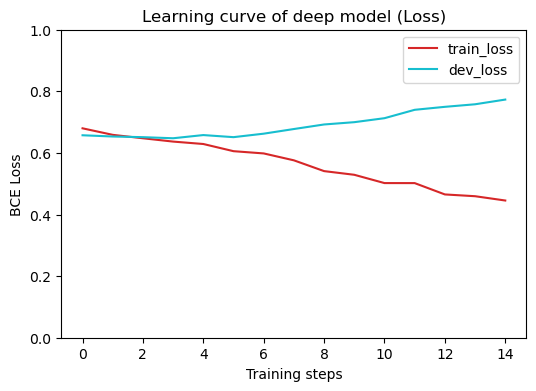

In [67]:
plot_learning_curve(best_loss_record, title='deep model')

### Evaluation on the validation set

In [68]:
# Convert to PyTorch tensors
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)

X_test_tensor = torch.FloatTensor(X_test)

# Define dataset and dataloaders
val_set = TensorDataset(X_val_tensor, y_val_tensor)
test_set = TensorDataset(X_test_tensor)

val_loader = DataLoader(val_set, config['batch_size'], drop_last=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, config['batch_size'], drop_last=False, num_workers=0, pin_memory=True)

Validation Loss: 0.6503, Validation Accuracy: 0.6101


/var/folders/st/jr2134cd02575p7pnq8xy5440000gn/T/ipykernel_30446/3426316151.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best

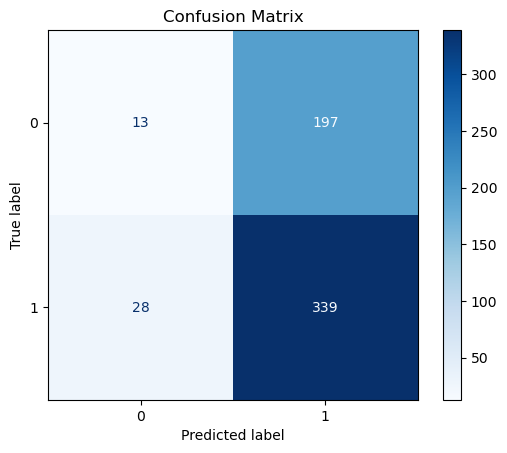

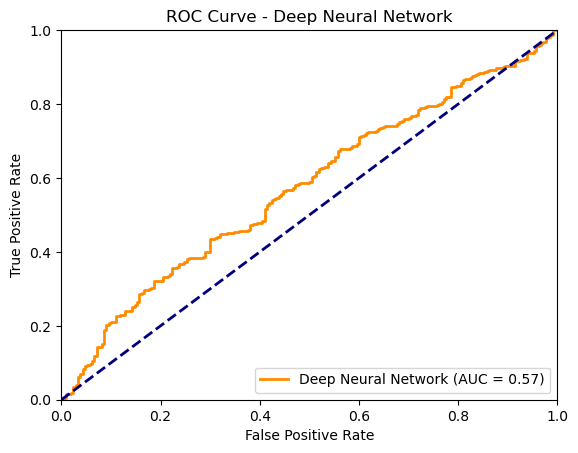

In [69]:
# Now load the best model and evaluate on the separate validation set
model = NeuralNet(input_dim=X_train.shape[1]).to(device)
model.load_state_dict(torch.load('models/best_kfold_model.pth'))  # Load the best model from K-Fold

dev_loss, dev_acc = dev(val_loader, model, device, nn.BCELoss())

print(f'Validation Loss: {dev_loss:.4f}, Validation Accuracy: {dev_acc:.4f}')

plot_pred(val_loader, model, device)  # Show prediction on the validation set

### Testing

In [21]:
# Save predictions to a CSV file
def save_pred(preds, case_ids, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['case_id', 'successful_appeal'])
        for case_id, p in zip(case_ids, preds):
            p = int(p)
            writer.writerow([case_id, p])

# Load case IDs from the test.jsonl file
def load_case_ids(jsonl_file):
    ''' Load case_ids from the test.jsonl file '''
    case_ids = []
    with open(jsonl_file, 'r') as f:
        for line in f:
            data = json.loads(line)
            case_ids.append(data['case_id'])
    return case_ids


# Load case IDs from the original test.jsonl file
test_jsonl_file = 'Data/test.jsonl'  
case_ids = load_case_ids(test_jsonl_file)

# Get predictions from your model
preds = test(test_loader, model, device)

# Save predictions with real case_ids
save_pred(preds, case_ids, 'DNN-pred.csv')


Saving results to DNN-pred.csv


## Continue to do the Task using further features (x14 and/or x15)

### Add x14

In [128]:
# Read in the data
train_set = pd.read_csv('Data/train_processed.csv')
dev_set = pd.read_csv('Data/dev_processed.csv')

In [129]:
# Feature columns
columns_1 = ['issue_area_Attorneys', 'issue_area_Civil Rights', 'issue_area_Criminal Procedure', 'issue_area_Due Process', 'issue_area_Economic Activity', 'issue_area_Federal Taxation', 'issue_area_Federalism', 'issue_area_First Amendment', 'issue_area_Interstate Relations', 'issue_area_Judicial Power', 'issue_area_Miscellaneous', 'issue_area_Privacy', 'issue_area_Private Action', 'issue_area_UNKNOWN', 'issue_area_Unions',
            'file_year_2000_2010', 'file_year_2010_2020', 'file_year_before_2000', 'argument_quarter_1.0', 'argument_quarter_2.0', 'argument_quarter_3.0', 'argument_quarter_4.0', 'argument_quarter_nan',
            'court_hearing_length', 'utterances_number','lagged_time', 'speech_rate', 'hearing_length_months']
columns_2 = ['successful_appeal']

# Filter the columns for the train and dev sets
final_columns = columns_1 + [f'embedding_{i}' for i in range(1, 385)] + columns_2
train_set = train_set[final_columns]
dev_set = dev_set[final_columns]

In [130]:
# Split data into features and target
X_train = train_set.drop(columns=['successful_appeal']).values
y_train = train_set['successful_appeal'].values

X_val = dev_set.drop(columns=['successful_appeal']).values
y_val = dev_set['successful_appeal'].values

In [131]:
best_loss_record = k_fold_cross_validation(X_train, y_train, k_folds=5)

Fold 1/5
Epoch 1/200, Training Loss: 0.7055, Validation Loss: 0.6851, Train Acc: 0.5094, Val Acc: 0.6219
Saving model at epoch 1, validation loss: 0.6851
Epoch 2/200, Training Loss: 0.6611, Validation Loss: 0.6671, Train Acc: 0.6256, Val Acc: 0.6295
Saving model at epoch 2, validation loss: 0.6671
Epoch 3/200, Training Loss: 0.6451, Validation Loss: 0.6604, Train Acc: 0.6346, Val Acc: 0.6371
Saving model at epoch 3, validation loss: 0.6604


/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 4/200, Training Loss: 0.6323, Validation Loss: 0.6614, Train Acc: 0.6400, Val Acc: 0.6295
Epoch 5/200, Training Loss: 0.6217, Validation Loss: 0.6687, Train Acc: 0.6541, Val Acc: 0.6067
Epoch 6/200, Training Loss: 0.5975, Validation Loss: 0.6743, Train Acc: 0.6734, Val Acc: 0.6273
Epoch 7/200, Training Loss: 0.5897, Validation Loss: 0.6860, Train Acc: 0.6858, Val Acc: 0.5720
Epoch 8/200, Training Loss: 0.5662, Validation Loss: 0.6936, Train Acc: 0.7102, Val Acc: 0.5796
Epoch 9/200, Training Loss: 0.5494, Validation Loss: 0.6999, Train Acc: 0.7230, Val Acc: 0.5612
Epoch 10/200, Training Loss: 0.5317, Validation Loss: 0.7106, Train Acc: 0.7316, Val Acc: 0.5645
Epoch 11/200, Training Loss: 0.5202, Validation Loss: 0.7197, Train Acc: 0.7490, Val Acc: 0.5623
Epoch 12/200, Training Loss: 0.5035, Validation Loss: 0.7223, Train Acc: 0.7528, Val Acc: 0.5623
Epoch 13/200, Training Loss: 0.4873, Validation Loss: 0.7280, Train Acc: 0.7652, Val Acc: 0.5536
Epoch 14/200, Training Loss: 0.4800,

/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 3/200, Training Loss: 0.6505, Validation Loss: 0.6497, Train Acc: 0.6346, Val Acc: 0.6425
Saving model at epoch 3, validation loss: 0.6497
Epoch 4/200, Training Loss: 0.6429, Validation Loss: 0.6492, Train Acc: 0.6446, Val Acc: 0.6511
Saving model at epoch 4, validation loss: 0.6492
Epoch 5/200, Training Loss: 0.6311, Validation Loss: 0.6555, Train Acc: 0.6462, Val Acc: 0.6544
Epoch 6/200, Training Loss: 0.6164, Validation Loss: 0.6577, Train Acc: 0.6509, Val Acc: 0.6436
Epoch 7/200, Training Loss: 0.6004, Validation Loss: 0.6636, Train Acc: 0.6771, Val Acc: 0.6371
Epoch 8/200, Training Loss: 0.5776, Validation Loss: 0.6815, Train Acc: 0.6967, Val Acc: 0.5980
Epoch 9/200, Training Loss: 0.5609, Validation Loss: 0.6819, Train Acc: 0.7029, Val Acc: 0.6024
Epoch 10/200, Training Loss: 0.5415, Validation Loss: 0.6847, Train Acc: 0.7324, Val Acc: 0.6089
Epoch 11/200, Training Loss: 0.5341, Validation Loss: 0.6943, Train Acc: 0.7300, Val Acc: 0.5959
Epoch 12/200, Training Loss: 0.5213,

/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 3/200, Training Loss: 0.6549, Validation Loss: 0.6654, Train Acc: 0.6157, Val Acc: 0.6280
Saving model at epoch 3, validation loss: 0.6654
Epoch 4/200, Training Loss: 0.6480, Validation Loss: 0.6616, Train Acc: 0.6442, Val Acc: 0.6258
Saving model at epoch 4, validation loss: 0.6616
Epoch 5/200, Training Loss: 0.6299, Validation Loss: 0.6570, Train Acc: 0.6463, Val Acc: 0.6236
Saving model at epoch 5, validation loss: 0.6570
Epoch 6/200, Training Loss: 0.6201, Validation Loss: 0.6587, Train Acc: 0.6556, Val Acc: 0.6106
Epoch 7/200, Training Loss: 0.5996, Validation Loss: 0.6708, Train Acc: 0.6713, Val Acc: 0.6030
Epoch 8/200, Training Loss: 0.5765, Validation Loss: 0.6793, Train Acc: 0.6949, Val Acc: 0.5976
Epoch 9/200, Training Loss: 0.5640, Validation Loss: 0.6898, Train Acc: 0.7019, Val Acc: 0.6009
Epoch 10/200, Training Loss: 0.5402, Validation Loss: 0.6926, Train Acc: 0.7257, Val Acc: 0.5781
Epoch 11/200, Training Loss: 0.5251, Validation Loss: 0.7128, Train Acc: 0.7274, Val

/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 2/200, Training Loss: 0.6759, Validation Loss: 0.6587, Train Acc: 0.5913, Val Acc: 0.6486
Saving model at epoch 2, validation loss: 0.6587
Epoch 3/200, Training Loss: 0.6531, Validation Loss: 0.6501, Train Acc: 0.6241, Val Acc: 0.6421
Saving model at epoch 3, validation loss: 0.6501
Epoch 4/200, Training Loss: 0.6409, Validation Loss: 0.6457, Train Acc: 0.6379, Val Acc: 0.6497
Saving model at epoch 4, validation loss: 0.6457
Epoch 5/200, Training Loss: 0.6356, Validation Loss: 0.6461, Train Acc: 0.6423, Val Acc: 0.6421
Epoch 6/200, Training Loss: 0.6178, Validation Loss: 0.6486, Train Acc: 0.6640, Val Acc: 0.6399
Epoch 7/200, Training Loss: 0.6011, Validation Loss: 0.6580, Train Acc: 0.6710, Val Acc: 0.6388
Epoch 8/200, Training Loss: 0.5878, Validation Loss: 0.6569, Train Acc: 0.6862, Val Acc: 0.6377
Epoch 9/200, Training Loss: 0.5606, Validation Loss: 0.6658, Train Acc: 0.7043, Val Acc: 0.6291
Epoch 10/200, Training Loss: 0.5575, Validation Loss: 0.6727, Train Acc: 0.7100, Val 

/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 4/200, Training Loss: 0.6427, Validation Loss: 0.6629, Train Acc: 0.6322, Val Acc: 0.6128
Saving model at epoch 4, validation loss: 0.6629
Epoch 5/200, Training Loss: 0.6335, Validation Loss: 0.6662, Train Acc: 0.6466, Val Acc: 0.6030
Epoch 6/200, Training Loss: 0.6188, Validation Loss: 0.6623, Train Acc: 0.6577, Val Acc: 0.6020
Saving model at epoch 6, validation loss: 0.6623
Epoch 7/200, Training Loss: 0.5976, Validation Loss: 0.6665, Train Acc: 0.6715, Val Acc: 0.6095
Epoch 8/200, Training Loss: 0.5821, Validation Loss: 0.6714, Train Acc: 0.6959, Val Acc: 0.5976
Epoch 9/200, Training Loss: 0.5662, Validation Loss: 0.6871, Train Acc: 0.7014, Val Acc: 0.5987
Epoch 10/200, Training Loss: 0.5508, Validation Loss: 0.7062, Train Acc: 0.7084, Val Acc: 0.5976
Epoch 11/200, Training Loss: 0.5247, Validation Loss: 0.7000, Train Acc: 0.7350, Val Acc: 0.5976
Epoch 12/200, Training Loss: 0.5135, Validation Loss: 0.7172, Train Acc: 0.7409, Val Acc: 0.5911
Epoch 13/200, Training Loss: 0.4980

/var/folders/st/jr2134cd02575p7pnq8xy5440000gn/T/ipykernel_96258/344920602.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_state = torch.load(f'models/model-

Validation Loss: 0.6539, Validation Accuracy: 0.6360


/var/folders/st/jr2134cd02575p7pnq8xy5440000gn/T/ipykernel_96258/4149697481.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/bes

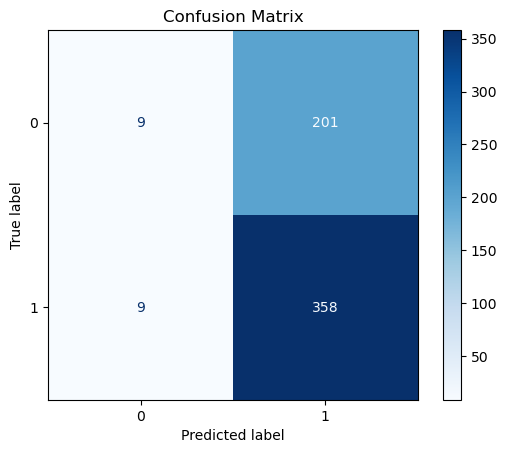

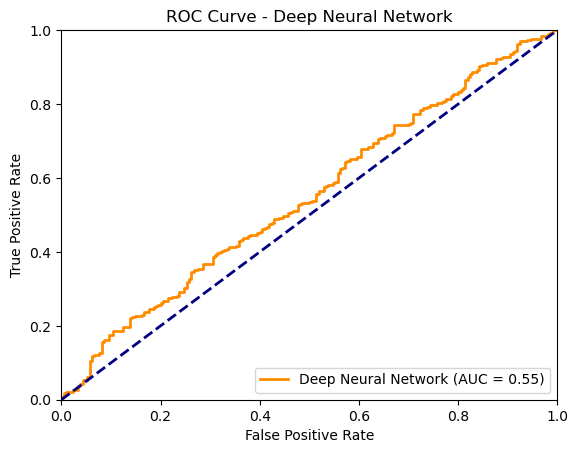

In [132]:
# Convert to PyTorch tensors
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)

# Define dataset and dataloaders
val_set = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_set, config['batch_size'], drop_last=False, num_workers=0, pin_memory=True)

# Now load the best model and evaluate on the separate validation set
model = NeuralNet(input_dim=X_train.shape[1]).to(device)
model.load_state_dict(torch.load('models/best_kfold_model.pth'))  # Load the best model from K-Fold

dev_loss, dev_acc = dev(val_loader, model, device, nn.BCELoss())

print(f'Validation Loss: {dev_loss:.4f}, Validation Accuracy: {dev_acc:.4f}')

plot_pred(val_loader, model, device)  # Show prediction on the validation set

### Add x15

In [133]:
# Read in the data
train_set = pd.read_csv('Data/train_processed.csv')
dev_set = pd.read_csv('Data/dev_processed.csv')

In [134]:
# Feature columns
columns_1 = ['issue_area_Attorneys', 'issue_area_Civil Rights', 'issue_area_Criminal Procedure', 'issue_area_Due Process', 'issue_area_Economic Activity', 'issue_area_Federal Taxation', 'issue_area_Federalism', 'issue_area_First Amendment', 'issue_area_Interstate Relations', 'issue_area_Judicial Power', 'issue_area_Miscellaneous', 'issue_area_Privacy', 'issue_area_Private Action', 'issue_area_UNKNOWN', 'issue_area_Unions',
            'file_year_2000_2010', 'file_year_2010_2020', 'file_year_before_2000', 'argument_quarter_1.0', 'argument_quarter_2.0', 'argument_quarter_3.0', 'argument_quarter_4.0', 'argument_quarter_nan',
            'court_hearing_length', 'utterances_number','lagged_time', 'speech_rate', 'majority_ratio']
columns_2 = ['successful_appeal']

# Filter the columns for the train and dev sets
final_columns = columns_1 + [f'embedding_{i}' for i in range(1, 385)] + columns_2
train_set = train_set[final_columns]
dev_set = dev_set[final_columns]

In [135]:
# Split data into features and target
X_train = train_set.drop(columns=['successful_appeal']).values
y_train = train_set['successful_appeal'].values

X_val = dev_set.drop(columns=['successful_appeal']).values
y_val = dev_set['successful_appeal'].values

In [136]:
best_loss_record = k_fold_cross_validation(X_train, y_train, k_folds=5)

Fold 1/5
Epoch 1/200, Training Loss: 0.7430, Validation Loss: 0.7103, Train Acc: 0.4424, Val Acc: 0.3684
Saving model at epoch 1, validation loss: 0.7103
Epoch 2/200, Training Loss: 0.6769, Validation Loss: 0.6732, Train Acc: 0.5725, Val Acc: 0.5980
Saving model at epoch 2, validation loss: 0.6732
Epoch 3/200, Training Loss: 0.6475, Validation Loss: 0.6626, Train Acc: 0.6321, Val Acc: 0.6230
Saving model at epoch 3, validation loss: 0.6626
Epoch 4/200, Training Loss: 0.6294, Validation Loss: 0.6637, Train Acc: 0.6571, Val Acc: 0.5948


/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 5/200, Training Loss: 0.6166, Validation Loss: 0.6682, Train Acc: 0.6593, Val Acc: 0.5915
Epoch 6/200, Training Loss: 0.6006, Validation Loss: 0.6726, Train Acc: 0.6807, Val Acc: 0.5991
Epoch 7/200, Training Loss: 0.5810, Validation Loss: 0.6811, Train Acc: 0.6915, Val Acc: 0.6056
Epoch 8/200, Training Loss: 0.5650, Validation Loss: 0.6812, Train Acc: 0.7075, Val Acc: 0.5840
Epoch 9/200, Training Loss: 0.5475, Validation Loss: 0.6930, Train Acc: 0.7165, Val Acc: 0.5926
Epoch 10/200, Training Loss: 0.5288, Validation Loss: 0.7053, Train Acc: 0.7327, Val Acc: 0.5785
Epoch 11/200, Training Loss: 0.5151, Validation Loss: 0.7148, Train Acc: 0.7446, Val Acc: 0.5915
Epoch 12/200, Training Loss: 0.4995, Validation Loss: 0.7177, Train Acc: 0.7606, Val Acc: 0.5764
Epoch 13/200, Training Loss: 0.4860, Validation Loss: 0.7222, Train Acc: 0.7709, Val Acc: 0.5785
Epoch 14/200, Training Loss: 0.4747, Validation Loss: 0.7312, Train Acc: 0.7658, Val Acc: 0.5753
Early stopping at epoch 14
Finished

/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/200, Training Loss: 0.7667, Validation Loss: 0.6765, Train Acc: 0.4329, Val Acc: 0.6414
Saving model at epoch 1, validation loss: 0.6765
Epoch 2/200, Training Loss: 0.6879, Validation Loss: 0.6701, Train Acc: 0.5530, Val Acc: 0.6143
Saving model at epoch 2, validation loss: 0.6701
Epoch 3/200, Training Loss: 0.6554, Validation Loss: 0.6548, Train Acc: 0.6256, Val Acc: 0.6241
Saving model at epoch 3, validation loss: 0.6548
Epoch 4/200, Training Loss: 0.6345, Validation Loss: 0.6469, Train Acc: 0.6438, Val Acc: 0.6306
Saving model at epoch 4, validation loss: 0.6469
Epoch 5/200, Training Loss: 0.6273, Validation Loss: 0.6474, Train Acc: 0.6449, Val Acc: 0.6338
Epoch 6/200, Training Loss: 0.6087, Validation Loss: 0.6432, Train Acc: 0.6739, Val Acc: 0.6555
Saving model at epoch 6, validation loss: 0.6432
Epoch 7/200, Training Loss: 0.5997, Validation Loss: 0.6452, Train Acc: 0.6872, Val Acc: 0.6327
Epoch 8/200, Training Loss: 0.5865, Validation Loss: 0.6512, Train Acc: 0.7018, Val

/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 3/200, Training Loss: 0.6474, Validation Loss: 0.6536, Train Acc: 0.6287, Val Acc: 0.6226
Saving model at epoch 3, validation loss: 0.6536
Epoch 4/200, Training Loss: 0.6328, Validation Loss: 0.6513, Train Acc: 0.6369, Val Acc: 0.6139
Saving model at epoch 4, validation loss: 0.6513
Epoch 5/200, Training Loss: 0.6210, Validation Loss: 0.6533, Train Acc: 0.6556, Val Acc: 0.6030
Epoch 6/200, Training Loss: 0.6073, Validation Loss: 0.6530, Train Acc: 0.6653, Val Acc: 0.6182
Epoch 7/200, Training Loss: 0.5913, Validation Loss: 0.6603, Train Acc: 0.6789, Val Acc: 0.6182
Epoch 8/200, Training Loss: 0.5819, Validation Loss: 0.6732, Train Acc: 0.6883, Val Acc: 0.5933
Epoch 9/200, Training Loss: 0.5611, Validation Loss: 0.6733, Train Acc: 0.7171, Val Acc: 0.5954
Epoch 10/200, Training Loss: 0.5400, Validation Loss: 0.6805, Train Acc: 0.7190, Val Acc: 0.5987
Epoch 11/200, Training Loss: 0.5229, Validation Loss: 0.6902, Train Acc: 0.7369, Val Acc: 0.5857
Epoch 12/200, Training Loss: 0.5079,

/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 3/200, Training Loss: 0.6476, Validation Loss: 0.6457, Train Acc: 0.6287, Val Acc: 0.6453
Saving model at epoch 3, validation loss: 0.6457
Epoch 4/200, Training Loss: 0.6344, Validation Loss: 0.6438, Train Acc: 0.6491, Val Acc: 0.6432
Saving model at epoch 4, validation loss: 0.6438
Epoch 5/200, Training Loss: 0.6228, Validation Loss: 0.6409, Train Acc: 0.6631, Val Acc: 0.6356
Saving model at epoch 5, validation loss: 0.6409
Epoch 6/200, Training Loss: 0.6114, Validation Loss: 0.6466, Train Acc: 0.6707, Val Acc: 0.6367
Epoch 7/200, Training Loss: 0.5950, Validation Loss: 0.6502, Train Acc: 0.6748, Val Acc: 0.6139
Epoch 8/200, Training Loss: 0.5819, Validation Loss: 0.6534, Train Acc: 0.6908, Val Acc: 0.6182
Epoch 9/200, Training Loss: 0.5595, Validation Loss: 0.6675, Train Acc: 0.7065, Val Acc: 0.6204
Epoch 10/200, Training Loss: 0.5443, Validation Loss: 0.6672, Train Acc: 0.7249, Val Acc: 0.6161
Epoch 11/200, Training Loss: 0.5141, Validation Loss: 0.6787, Train Acc: 0.7409, Val

/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/200, Training Loss: 0.7299, Validation Loss: 0.6954, Train Acc: 0.4642, Val Acc: 0.4685
Saving model at epoch 1, validation loss: 0.6954
Epoch 2/200, Training Loss: 0.6750, Validation Loss: 0.6791, Train Acc: 0.5770, Val Acc: 0.5770
Saving model at epoch 2, validation loss: 0.6791
Epoch 3/200, Training Loss: 0.6480, Validation Loss: 0.6682, Train Acc: 0.6328, Val Acc: 0.5965
Saving model at epoch 3, validation loss: 0.6682
Epoch 4/200, Training Loss: 0.6309, Validation Loss: 0.6684, Train Acc: 0.6512, Val Acc: 0.5944
Epoch 5/200, Training Loss: 0.6159, Validation Loss: 0.6615, Train Acc: 0.6602, Val Acc: 0.5998
Saving model at epoch 5, validation loss: 0.6615
Epoch 6/200, Training Loss: 0.5998, Validation Loss: 0.6772, Train Acc: 0.6764, Val Acc: 0.6009
Epoch 7/200, Training Loss: 0.5927, Validation Loss: 0.6845, Train Acc: 0.6837, Val Acc: 0.6030
Epoch 8/200, Training Loss: 0.5571, Validation Loss: 0.6931, Train Acc: 0.7081, Val Acc: 0.5868
Epoch 9/200, Training Loss: 0.5485, 

/var/folders/st/jr2134cd02575p7pnq8xy5440000gn/T/ipykernel_96258/344920602.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_state = torch.load(f'models/model-

Validation Loss: 0.7354, Validation Accuracy: 0.5962


/var/folders/st/jr2134cd02575p7pnq8xy5440000gn/T/ipykernel_96258/4149697481.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/bes

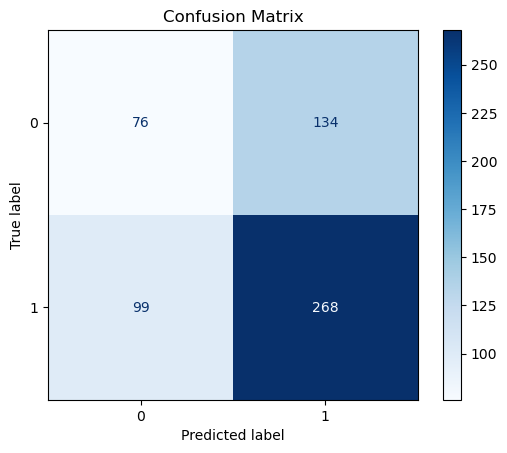

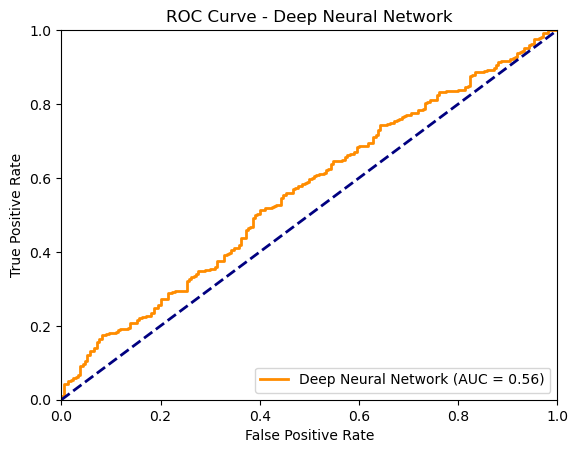

In [137]:
# Convert to PyTorch tensors
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)

# Define dataset and dataloaders
val_set = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_set, config['batch_size'], drop_last=False, num_workers=0, pin_memory=True)

# Now load the best model and evaluate on the separate validation set
model = NeuralNet(input_dim=X_train.shape[1]).to(device)
model.load_state_dict(torch.load('models/best_kfold_model.pth'))  # Load the best model from K-Fold

dev_loss, dev_acc = dev(val_loader, model, device, nn.BCELoss())

print(f'Validation Loss: {dev_loss:.4f}, Validation Accuracy: {dev_acc:.4f}')

plot_pred(val_loader, model, device)  # Show prediction on the validation set

### Add x14 and x15

In [138]:
# Read in the data
train_set = pd.read_csv('Data/train_processed.csv')
dev_set = pd.read_csv('Data/dev_processed.csv')

In [139]:
# Feature columns
columns_1 = ['issue_area_Attorneys', 'issue_area_Civil Rights', 'issue_area_Criminal Procedure', 'issue_area_Due Process', 'issue_area_Economic Activity', 'issue_area_Federal Taxation', 'issue_area_Federalism', 'issue_area_First Amendment', 'issue_area_Interstate Relations', 'issue_area_Judicial Power', 'issue_area_Miscellaneous', 'issue_area_Privacy', 'issue_area_Private Action', 'issue_area_UNKNOWN', 'issue_area_Unions',
            'file_year_2000_2010', 'file_year_2010_2020', 'file_year_before_2000', 'argument_quarter_1.0', 'argument_quarter_2.0', 'argument_quarter_3.0', 'argument_quarter_4.0', 'argument_quarter_nan',
            'court_hearing_length', 'utterances_number','lagged_time', 'speech_rate', 'hearing_length_months', 'majority_ratio']
columns_2 = ['successful_appeal']

# Filter the columns for the train and dev sets
final_columns = columns_1 + [f'embedding_{i}' for i in range(1, 385)] + columns_2
train_set = train_set[final_columns]
dev_set = dev_set[final_columns]

In [140]:
# Split data into features and target
X_train = train_set.drop(columns=['successful_appeal']).values
y_train = train_set['successful_appeal'].values

X_val = dev_set.drop(columns=['successful_appeal']).values
y_val = dev_set['successful_appeal'].values

In [141]:
best_loss_record = k_fold_cross_validation(X_train, y_train, k_folds=5)

Fold 1/5
Epoch 1/200, Training Loss: 0.7052, Validation Loss: 0.6866, Train Acc: 0.5091, Val Acc: 0.5850
Saving model at epoch 1, validation loss: 0.6866
Epoch 2/200, Training Loss: 0.6651, Validation Loss: 0.6625, Train Acc: 0.6129, Val Acc: 0.6295
Saving model at epoch 2, validation loss: 0.6625
Epoch 3/200, Training Loss: 0.6472, Validation Loss: 0.6546, Train Acc: 0.6425, Val Acc: 0.6241
Saving model at epoch 3, validation loss: 0.6546
Epoch 4/200, Training Loss: 0.6379, Validation Loss: 0.6555, Train Acc: 0.6378, Val Acc: 0.6241


/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 5/200, Training Loss: 0.6219, Validation Loss: 0.6536, Train Acc: 0.6555, Val Acc: 0.6306
Saving model at epoch 5, validation loss: 0.6536
Epoch 6/200, Training Loss: 0.6083, Validation Loss: 0.6598, Train Acc: 0.6717, Val Acc: 0.6230
Epoch 7/200, Training Loss: 0.5869, Validation Loss: 0.6724, Train Acc: 0.6885, Val Acc: 0.6046
Epoch 8/200, Training Loss: 0.5710, Validation Loss: 0.6827, Train Acc: 0.7032, Val Acc: 0.5937
Epoch 9/200, Training Loss: 0.5581, Validation Loss: 0.6991, Train Acc: 0.7102, Val Acc: 0.6002
Epoch 10/200, Training Loss: 0.5275, Validation Loss: 0.7026, Train Acc: 0.7327, Val Acc: 0.5807
Epoch 11/200, Training Loss: 0.5183, Validation Loss: 0.7200, Train Acc: 0.7425, Val Acc: 0.5926
Epoch 12/200, Training Loss: 0.4961, Validation Loss: 0.7328, Train Acc: 0.7647, Val Acc: 0.5775
Epoch 13/200, Training Loss: 0.4889, Validation Loss: 0.7473, Train Acc: 0.7615, Val Acc: 0.5785
Epoch 14/200, Training Loss: 0.4738, Validation Loss: 0.7543, Train Acc: 0.7704, Va

/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 6/200, Training Loss: 0.6124, Validation Loss: 0.6412, Train Acc: 0.6555, Val Acc: 0.6446
Epoch 7/200, Training Loss: 0.5963, Validation Loss: 0.6474, Train Acc: 0.6742, Val Acc: 0.6284
Epoch 8/200, Training Loss: 0.5809, Validation Loss: 0.6483, Train Acc: 0.6869, Val Acc: 0.6457
Epoch 9/200, Training Loss: 0.5593, Validation Loss: 0.6561, Train Acc: 0.7072, Val Acc: 0.6403
Epoch 10/200, Training Loss: 0.5516, Validation Loss: 0.6622, Train Acc: 0.7062, Val Acc: 0.6403
Epoch 11/200, Training Loss: 0.5387, Validation Loss: 0.6752, Train Acc: 0.7221, Val Acc: 0.6230
Epoch 12/200, Training Loss: 0.5271, Validation Loss: 0.6791, Train Acc: 0.7175, Val Acc: 0.6197
Epoch 13/200, Training Loss: 0.4988, Validation Loss: 0.6833, Train Acc: 0.7571, Val Acc: 0.6197
Epoch 14/200, Training Loss: 0.4927, Validation Loss: 0.6882, Train Acc: 0.7571, Val Acc: 0.6100
Epoch 15/200, Training Loss: 0.4833, Validation Loss: 0.6936, Train Acc: 0.7737, Val Acc: 0.6154
Early stopping at epoch 15
Finishe

/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 3/200, Training Loss: 0.6433, Validation Loss: 0.6460, Train Acc: 0.6420, Val Acc: 0.6345
Saving model at epoch 3, validation loss: 0.6460
Epoch 4/200, Training Loss: 0.6311, Validation Loss: 0.6434, Train Acc: 0.6488, Val Acc: 0.6399
Saving model at epoch 4, validation loss: 0.6434
Epoch 5/200, Training Loss: 0.6156, Validation Loss: 0.6469, Train Acc: 0.6575, Val Acc: 0.6236
Epoch 6/200, Training Loss: 0.6039, Validation Loss: 0.6435, Train Acc: 0.6691, Val Acc: 0.6291
Epoch 7/200, Training Loss: 0.5952, Validation Loss: 0.6521, Train Acc: 0.6808, Val Acc: 0.6345
Epoch 8/200, Training Loss: 0.5723, Validation Loss: 0.6574, Train Acc: 0.6949, Val Acc: 0.6236
Epoch 9/200, Training Loss: 0.5457, Validation Loss: 0.6645, Train Acc: 0.7201, Val Acc: 0.6171
Epoch 10/200, Training Loss: 0.5351, Validation Loss: 0.6695, Train Acc: 0.7236, Val Acc: 0.6247
Epoch 11/200, Training Loss: 0.5152, Validation Loss: 0.6796, Train Acc: 0.7407, Val Acc: 0.6247
Epoch 12/200, Training Loss: 0.5108,

/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 5/200, Training Loss: 0.6295, Validation Loss: 0.6539, Train Acc: 0.6561, Val Acc: 0.6161
Saving model at epoch 5, validation loss: 0.6539
Epoch 6/200, Training Loss: 0.6185, Validation Loss: 0.6535, Train Acc: 0.6675, Val Acc: 0.6106
Saving model at epoch 6, validation loss: 0.6535
Epoch 7/200, Training Loss: 0.6044, Validation Loss: 0.6562, Train Acc: 0.6672, Val Acc: 0.6085
Epoch 8/200, Training Loss: 0.5803, Validation Loss: 0.6598, Train Acc: 0.7024, Val Acc: 0.6193
Epoch 9/200, Training Loss: 0.5601, Validation Loss: 0.6540, Train Acc: 0.7136, Val Acc: 0.6334
Epoch 10/200, Training Loss: 0.5348, Validation Loss: 0.6795, Train Acc: 0.7241, Val Acc: 0.6226
Epoch 11/200, Training Loss: 0.5268, Validation Loss: 0.6820, Train Acc: 0.7320, Val Acc: 0.6041
Epoch 12/200, Training Loss: 0.4990, Validation Loss: 0.6966, Train Acc: 0.7491, Val Acc: 0.6106
Epoch 13/200, Training Loss: 0.4917, Validation Loss: 0.7074, Train Acc: 0.7561, Val Acc: 0.6171
Epoch 14/200, Training Loss: 0.484

/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 5/200, Training Loss: 0.6158, Validation Loss: 0.6571, Train Acc: 0.6664, Val Acc: 0.6139
Saving model at epoch 5, validation loss: 0.6571
Epoch 6/200, Training Loss: 0.6056, Validation Loss: 0.6669, Train Acc: 0.6707, Val Acc: 0.6106
Epoch 7/200, Training Loss: 0.5890, Validation Loss: 0.6603, Train Acc: 0.6816, Val Acc: 0.6095
Epoch 8/200, Training Loss: 0.5747, Validation Loss: 0.6707, Train Acc: 0.6978, Val Acc: 0.5944
Epoch 9/200, Training Loss: 0.5555, Validation Loss: 0.6842, Train Acc: 0.7108, Val Acc: 0.5933
Epoch 10/200, Training Loss: 0.5275, Validation Loss: 0.6852, Train Acc: 0.7320, Val Acc: 0.6052
Epoch 11/200, Training Loss: 0.5111, Validation Loss: 0.6962, Train Acc: 0.7482, Val Acc: 0.6041
Epoch 12/200, Training Loss: 0.4971, Validation Loss: 0.7046, Train Acc: 0.7537, Val Acc: 0.5944
Epoch 13/200, Training Loss: 0.4866, Validation Loss: 0.7210, Train Acc: 0.7580, Val Acc: 0.5813
Epoch 14/200, Training Loss: 0.4599, Validation Loss: 0.7274, Train Acc: 0.7864, Va

/var/folders/st/jr2134cd02575p7pnq8xy5440000gn/T/ipykernel_96258/344920602.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_state = torch.load(f'models/model-

Validation Loss: 0.6496, Validation Accuracy: 0.6360


/var/folders/st/jr2134cd02575p7pnq8xy5440000gn/T/ipykernel_96258/4149697481.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/bes

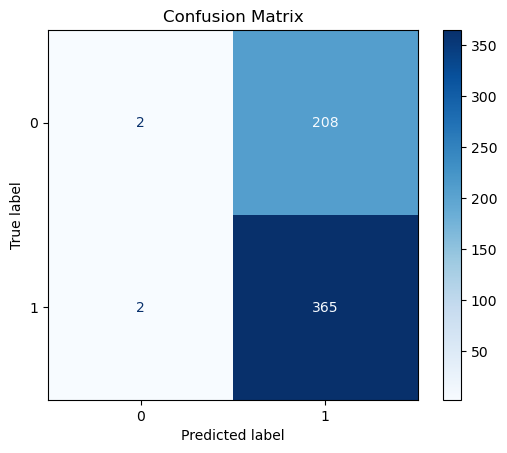

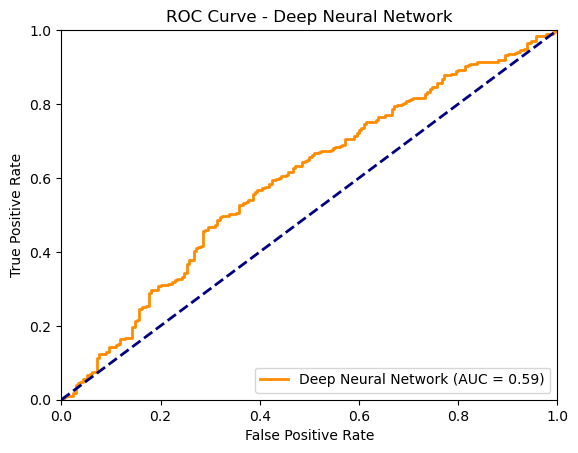

In [142]:
# Convert to PyTorch tensors
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)

# Define dataset and dataloaders
val_set = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_set, config['batch_size'], drop_last=False, num_workers=0, pin_memory=True)

# Now load the best model and evaluate on the separate validation set
model = NeuralNet(input_dim=X_train.shape[1]).to(device)
model.load_state_dict(torch.load('models/best_kfold_model.pth'))  # Load the best model from K-Fold

dev_loss, dev_acc = dev(val_loader, model, device, nn.BCELoss())

print(f'Validation Loss: {dev_loss:.4f}, Validation Accuracy: {dev_acc:.4f}')

plot_pred(val_loader, model, device)  # Show prediction on the validation set

### Explore if the political orientation of the judges impacts the decision

In [152]:
# Read in the data
train_set = pd.read_csv('Data/train_processed.csv')
dev_set = pd.read_csv('Data/dev_processed.csv')

In [153]:
# Feature columns
columns_1 = ['liberal_ratio']
columns_2 = ['successful_appeal']

# Filter the columns for the train and dev sets
final_columns = columns_1 + [f'embedding_{i}' for i in range(1, 385)] + columns_2
train_set = train_set[final_columns]
dev_set = dev_set[final_columns]

In [154]:
# Split data into features and target
X_train = train_set.drop(columns=['successful_appeal']).values
y_train = train_set['successful_appeal'].values

X_val = dev_set.drop(columns=['successful_appeal']).values
y_val = dev_set['successful_appeal'].values

In [155]:
best_loss_record = k_fold_cross_validation(X_train, y_train, k_folds=5)

Fold 1/5
Epoch 1/200, Training Loss: 0.7471, Validation Loss: 0.6702, Train Acc: 0.4532, Val Acc: 0.6371
Saving model at epoch 1, validation loss: 0.6702
Epoch 2/200, Training Loss: 0.6750, Validation Loss: 0.6632, Train Acc: 0.5744, Val Acc: 0.6403
Saving model at epoch 2, validation loss: 0.6632
Epoch 3/200, Training Loss: 0.6488, Validation Loss: 0.6659, Train Acc: 0.6286, Val Acc: 0.6197
Epoch 4/200, Training Loss: 0.6264, Validation Loss: 0.6702, Train Acc: 0.6579, Val Acc: 0.6013


/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 5/200, Training Loss: 0.6050, Validation Loss: 0.6758, Train Acc: 0.6641, Val Acc: 0.6067
Epoch 6/200, Training Loss: 0.5855, Validation Loss: 0.6822, Train Acc: 0.6883, Val Acc: 0.6197
Epoch 7/200, Training Loss: 0.5591, Validation Loss: 0.6852, Train Acc: 0.7064, Val Acc: 0.6013
Epoch 8/200, Training Loss: 0.5407, Validation Loss: 0.6970, Train Acc: 0.7306, Val Acc: 0.5991
Epoch 9/200, Training Loss: 0.5163, Validation Loss: 0.7118, Train Acc: 0.7509, Val Acc: 0.5926
Epoch 10/200, Training Loss: 0.5008, Validation Loss: 0.7278, Train Acc: 0.7625, Val Acc: 0.5948
Epoch 11/200, Training Loss: 0.4759, Validation Loss: 0.7275, Train Acc: 0.7734, Val Acc: 0.5970
Epoch 12/200, Training Loss: 0.4749, Validation Loss: 0.7343, Train Acc: 0.7815, Val Acc: 0.5894
Epoch 13/200, Training Loss: 0.4599, Validation Loss: 0.7369, Train Acc: 0.7856, Val Acc: 0.5850
Early stopping at epoch 13
Finished training after 12 epochs
Best model found in fold 1 with validation loss 0.6632
Fold 2/5
Epoch 1

/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 3/200, Training Loss: 0.6463, Validation Loss: 0.6596, Train Acc: 0.6408, Val Acc: 0.6262
Saving model at epoch 3, validation loss: 0.6596
Epoch 4/200, Training Loss: 0.6253, Validation Loss: 0.6535, Train Acc: 0.6555, Val Acc: 0.6241
Saving model at epoch 4, validation loss: 0.6535
Epoch 5/200, Training Loss: 0.5957, Validation Loss: 0.6626, Train Acc: 0.6804, Val Acc: 0.6219
Epoch 6/200, Training Loss: 0.5893, Validation Loss: 0.6685, Train Acc: 0.6891, Val Acc: 0.6338
Epoch 7/200, Training Loss: 0.5659, Validation Loss: 0.6835, Train Acc: 0.7105, Val Acc: 0.5915
Epoch 8/200, Training Loss: 0.5379, Validation Loss: 0.6891, Train Acc: 0.7289, Val Acc: 0.5883
Epoch 9/200, Training Loss: 0.5038, Validation Loss: 0.6996, Train Acc: 0.7577, Val Acc: 0.5872
Epoch 10/200, Training Loss: 0.4849, Validation Loss: 0.7076, Train Acc: 0.7680, Val Acc: 0.5959
Epoch 11/200, Training Loss: 0.4583, Validation Loss: 0.7188, Train Acc: 0.7888, Val Acc: 0.6046
Epoch 12/200, Training Loss: 0.4419,

/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 6/200, Training Loss: 0.5786, Validation Loss: 0.6805, Train Acc: 0.6995, Val Acc: 0.5954
Epoch 7/200, Training Loss: 0.5599, Validation Loss: 0.6970, Train Acc: 0.7019, Val Acc: 0.5824
Epoch 8/200, Training Loss: 0.5313, Validation Loss: 0.7164, Train Acc: 0.7217, Val Acc: 0.5846
Epoch 9/200, Training Loss: 0.5037, Validation Loss: 0.7225, Train Acc: 0.7496, Val Acc: 0.5759
Epoch 10/200, Training Loss: 0.4850, Validation Loss: 0.7431, Train Acc: 0.7642, Val Acc: 0.5868
Epoch 11/200, Training Loss: 0.4689, Validation Loss: 0.7416, Train Acc: 0.7759, Val Acc: 0.5889
Epoch 12/200, Training Loss: 0.4524, Validation Loss: 0.7668, Train Acc: 0.7892, Val Acc: 0.5922
Epoch 13/200, Training Loss: 0.4325, Validation Loss: 0.7705, Train Acc: 0.8043, Val Acc: 0.5792
Epoch 14/200, Training Loss: 0.4209, Validation Loss: 0.7760, Train Acc: 0.8081, Val Acc: 0.5922
Epoch 15/200, Training Loss: 0.3966, Validation Loss: 0.7783, Train Acc: 0.8276, Val Acc: 0.5770
Early stopping at epoch 15
Finishe

/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 2/200, Training Loss: 0.6852, Validation Loss: 0.6898, Train Acc: 0.5542, Val Acc: 0.5119
Saving model at epoch 2, validation loss: 0.6898
Epoch 3/200, Training Loss: 0.6511, Validation Loss: 0.6607, Train Acc: 0.6220, Val Acc: 0.6085
Saving model at epoch 3, validation loss: 0.6607
Epoch 4/200, Training Loss: 0.6345, Validation Loss: 0.6574, Train Acc: 0.6409, Val Acc: 0.6139
Saving model at epoch 4, validation loss: 0.6574
Epoch 5/200, Training Loss: 0.6106, Validation Loss: 0.6654, Train Acc: 0.6756, Val Acc: 0.5748
Epoch 6/200, Training Loss: 0.5888, Validation Loss: 0.6645, Train Acc: 0.6797, Val Acc: 0.6074
Epoch 7/200, Training Loss: 0.5705, Validation Loss: 0.6696, Train Acc: 0.6995, Val Acc: 0.6020
Epoch 8/200, Training Loss: 0.5446, Validation Loss: 0.6862, Train Acc: 0.7255, Val Acc: 0.5727
Epoch 9/200, Training Loss: 0.5248, Validation Loss: 0.6862, Train Acc: 0.7458, Val Acc: 0.5694
Epoch 10/200, Training Loss: 0.4948, Validation Loss: 0.7049, Train Acc: 0.7634, Val 

/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 5/200, Training Loss: 0.6073, Validation Loss: 0.6882, Train Acc: 0.6569, Val Acc: 0.6095
Epoch 6/200, Training Loss: 0.5825, Validation Loss: 0.6960, Train Acc: 0.6799, Val Acc: 0.5824
Epoch 7/200, Training Loss: 0.5562, Validation Loss: 0.7097, Train Acc: 0.7168, Val Acc: 0.5662
Epoch 8/200, Training Loss: 0.5360, Validation Loss: 0.7168, Train Acc: 0.7274, Val Acc: 0.5672
Epoch 9/200, Training Loss: 0.5180, Validation Loss: 0.7260, Train Acc: 0.7379, Val Acc: 0.5748
Epoch 10/200, Training Loss: 0.4981, Validation Loss: 0.7424, Train Acc: 0.7588, Val Acc: 0.5488
Epoch 11/200, Training Loss: 0.4682, Validation Loss: 0.7570, Train Acc: 0.7762, Val Acc: 0.5651
Epoch 12/200, Training Loss: 0.4553, Validation Loss: 0.7617, Train Acc: 0.7967, Val Acc: 0.5531
Epoch 13/200, Training Loss: 0.4408, Validation Loss: 0.7691, Train Acc: 0.7949, Val Acc: 0.5412
Epoch 14/200, Training Loss: 0.4144, Validation Loss: 0.7784, Train Acc: 0.8209, Val Acc: 0.5694
Early stopping at epoch 14
Finished

/var/folders/st/jr2134cd02575p7pnq8xy5440000gn/T/ipykernel_96258/344920602.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_state = torch.load(f'models/model-

Validation Loss: 0.6719, Validation Accuracy: 0.6291


/var/folders/st/jr2134cd02575p7pnq8xy5440000gn/T/ipykernel_96258/4149697481.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/bes

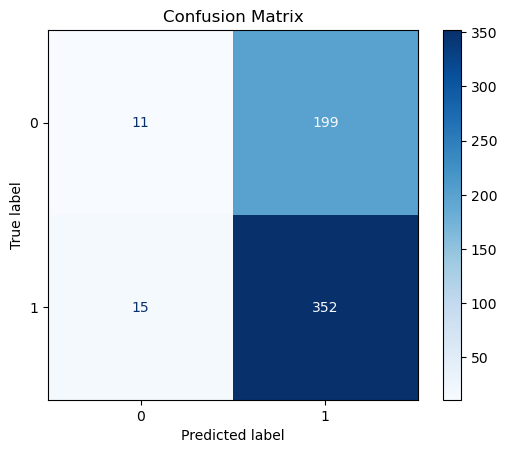

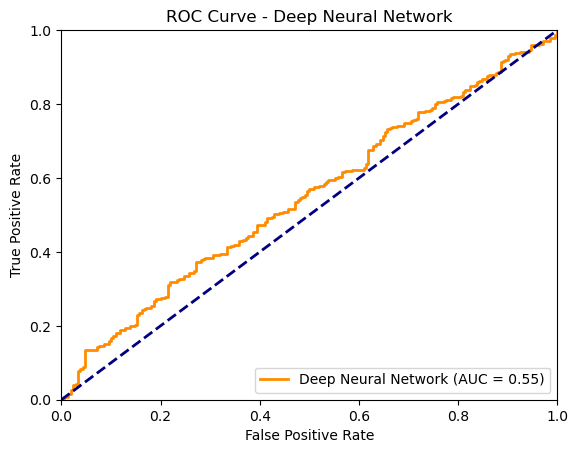

In [156]:
# Convert to PyTorch tensors
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)

# Define dataset and dataloaders
val_set = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_set, config['batch_size'], drop_last=False, num_workers=0, pin_memory=True)

# Now load the best model and evaluate on the separate validation set
model = NeuralNet(input_dim=X_train.shape[1]).to(device)
model.load_state_dict(torch.load('models/best_kfold_model.pth'))  # Load the best model from K-Fold

dev_loss, dev_acc = dev(val_loader, model, device, nn.BCELoss())

print(f'Validation Loss: {dev_loss:.4f}, Validation Accuracy: {dev_acc:.4f}')

plot_pred(val_loader, model, device)  # Show prediction on the validation set